Target: \
Stabilize the model training and achieve the desired performance of 99.40 on test data.

Results: \
Parameters: 9,426 \
Best Train Accuracy: 99.33 \
Best Test Accuracy: 99.40

Analysis: \
No Overfitting as performance on test data is close to train data. \
Training is stable as accuracy keeps increasing with every epoch and remains stable. Achived 99.40 test accuracy for last 3 epochs and 99.30-99.38 in earlier epochs.

# Import Libraries

In [ ]:
# load required libraries
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from tqdm import tqdm

## Data Transformations


In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.RandomRotation((-7.0, 7.0)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                      ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.1307,), (0.3081,))
                                     ])


# Dataset and Creating Train/Test Split

In [ ]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Dataloader Arguments & Test/Train Dataloaders


In [ ]:
SEED = 1
batch_size = 64

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=batch_size, num_workers=4, pin_memory=True) if cuda else \
                  dict(shuffle=True, batch_size=batch_size//2)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The model

In [ ]:
# construct cnn class
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 96, kernel_size = 5, padding = 2)  # apply 64 channel convolution with kernel size 5*5 on image
        self.conv2 = nn.Conv2d(96, 16, kernel_size = 1)  # apply 64 channel convolution with kernel size 1*1 on image
        self.conv3 = nn.Conv2d(16, 16, kernel_size = 3)  # apply 64 channel convolution with kernel size 3*3 on image
        self.conv4 = nn.Conv2d(16, 8, kernel_size = 1)  # apply 64 channel convolution with kernel size 1*1 on image
        self.conv5 = nn.Conv2d(8, 16, kernel_size = 3)  # apply 64 channel convolution with kernel size 3*3 on image
        self.conv6 = nn.Conv2d(16, 10, kernel_size = 3)  # apply 64 channel convolution with kernel size 3*3 on image

        self.batch_norm1 = nn.BatchNorm2d(96)  # batch normalization after convolution layer 1
        self.batch_norm2 = nn.BatchNorm2d(16)  # batch normalization after convolution layer 2
        self.batch_norm3 = nn.BatchNorm2d(16)  # batch normalization after convolution layer 3
        self.batch_norm4 = nn.BatchNorm2d(8)  # batch normalization after convolution layer 4
        self.batch_norm5 = nn.BatchNorm2d(16)  # batch normalization after convolution layer 5

        self.dropout = nn.Dropout(0.05)

        self.gap = nn.AdaptiveAvgPool2d(1)


    def forward(self, img):
        x = F.relu(self.batch_norm1(self.conv1(img)))  # input = 1 * 28 * 28, output = 96 * 28 * 28, rf = 5*5
        x = F.relu(self.batch_norm2(self.conv2(x)))  # input = 96 * 28 * 28, output = 16 * 28 * 28, rf = 5*5
        x = F.max_pool2d(x, 2)  # input = 16 * 28 * 28, output = 16 * 14 * 14, rf = 6*6
        x = self.dropout(x)

        x = F.relu(self.batch_norm3(self.conv3(x)))  # input = 16 * 14 * 14, output = 16 * 12 * 12, rf = 10*10
        x = F.relu(self.batch_norm4(self.conv4(x)))  # input = 16 * 12 * 12, output = 8 * 12 * 12, rf = 10*10
        x = F.max_pool2d(x, 2)  # input = 8 * 12 * 12, output = 8 * 6 * 6, rf = 12*12
        x = self.dropout(x)
        
        x = F.relu(self.batch_norm5(self.conv5(x)))  # input = 8 * 6 * 6, output = 16 * 4 * 4, rf = 20*20
        x = self.conv6(x)  # input = 16 * 4 * 4, output = 10 * 2 * 2, rf = 28*28
        x = self.gap(x)  # input = 10 * 2 *2, output = 10 * 1 * 1, rf = 32*32
        x = x.view(-1, 10)  # flatten cnn embedding

        img_out = F.log_softmax(x, dim = 1)  # output layer to output probabilities for label

        return img_out

# Model Params

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 28, 28]           2,496
       BatchNorm2d-2           [-1, 96, 28, 28]             192
            Conv2d-3           [-1, 16, 28, 28]           1,552
       BatchNorm2d-4           [-1, 16, 28, 28]              32
           Dropout-5           [-1, 16, 14, 14]               0
            Conv2d-6           [-1, 16, 12, 12]           2,320
       BatchNorm2d-7           [-1, 16, 12, 12]              32
            Conv2d-8            [-1, 8, 12, 12]             136
       BatchNorm2d-9            [-1, 8, 12, 12]              16
          Dropout-10              [-1, 8, 6, 6]               0
           Conv2d-11             [-1, 16, 4, 4]           1,168
      BatchNorm2d-12             [-1, 16, 4, 4]              32

# Training and Testing

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss.item())

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader, split="Test"):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\n{} set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        split, test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [ ]:
from torch.optim.lr_scheduler import StepLR

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=0.04666141793131828 Batch_id=937 Accuracy=94.18: 100%|██████████| 938/938 [00:08<00:00, 106.57it/s]



Test set: Average loss: 0.0565, Accuracy: 9818/10000 (98.18%)

EPOCH: 1


Loss=0.09398200362920761 Batch_id=937 Accuracy=97.84: 100%|██████████| 938/938 [00:07<00:00, 118.29it/s]



Test set: Average loss: 0.0393, Accuracy: 9881/10000 (98.81%)

EPOCH: 2


Loss=0.014432268217206001 Batch_id=937 Accuracy=98.16: 100%|██████████| 938/938 [00:07<00:00, 121.17it/s]



Test set: Average loss: 0.0306, Accuracy: 9909/10000 (99.09%)

EPOCH: 3


Loss=0.006781352683901787 Batch_id=937 Accuracy=98.36: 100%|██████████| 938/938 [00:07<00:00, 123.05it/s]



Test set: Average loss: 0.0292, Accuracy: 9917/10000 (99.17%)

EPOCH: 4


Loss=0.007954735308885574 Batch_id=937 Accuracy=98.55: 100%|██████████| 938/938 [00:07<00:00, 121.83it/s]



Test set: Average loss: 0.0319, Accuracy: 9901/10000 (99.01%)

EPOCH: 5


Loss=0.04459052160382271 Batch_id=937 Accuracy=98.79: 100%|██████████| 938/938 [00:07<00:00, 121.09it/s]



Test set: Average loss: 0.0216, Accuracy: 9936/10000 (99.36%)

EPOCH: 6


Loss=0.02837185189127922 Batch_id=937 Accuracy=98.95: 100%|██████████| 938/938 [00:07<00:00, 120.90it/s]



Test set: Average loss: 0.0211, Accuracy: 9938/10000 (99.38%)

EPOCH: 7


Loss=0.02394060790538788 Batch_id=937 Accuracy=98.98: 100%|██████████| 938/938 [00:07<00:00, 120.56it/s]



Test set: Average loss: 0.0206, Accuracy: 9934/10000 (99.34%)

EPOCH: 8


Loss=0.02290717139840126 Batch_id=937 Accuracy=99.02: 100%|██████████| 938/938 [00:07<00:00, 119.36it/s]



Test set: Average loss: 0.0201, Accuracy: 9936/10000 (99.36%)

EPOCH: 9


Loss=0.035111334174871445 Batch_id=937 Accuracy=99.02: 100%|██████████| 938/938 [00:07<00:00, 121.70it/s]



Test set: Average loss: 0.0204, Accuracy: 9934/10000 (99.34%)

EPOCH: 10


Loss=0.0072777424938976765 Batch_id=937 Accuracy=99.05: 100%|██████████| 938/938 [00:07<00:00, 122.14it/s]



Test set: Average loss: 0.0202, Accuracy: 9935/10000 (99.35%)

EPOCH: 11


Loss=0.052780941128730774 Batch_id=937 Accuracy=99.04: 100%|██████████| 938/938 [00:07<00:00, 120.60it/s]



Test set: Average loss: 0.0199, Accuracy: 9936/10000 (99.36%)

EPOCH: 12


Loss=0.0023615683894604445 Batch_id=937 Accuracy=99.04: 100%|██████████| 938/938 [00:07<00:00, 120.86it/s]



Test set: Average loss: 0.0196, Accuracy: 9940/10000 (99.40%)

EPOCH: 13


Loss=0.04156742990016937 Batch_id=937 Accuracy=99.03: 100%|██████████| 938/938 [00:07<00:00, 120.17it/s]



Test set: Average loss: 0.0197, Accuracy: 9940/10000 (99.40%)

EPOCH: 14


Loss=0.004937621299177408 Batch_id=937 Accuracy=99.00: 100%|██████████| 938/938 [00:07<00:00, 117.78it/s]



Test set: Average loss: 0.0200, Accuracy: 9940/10000 (99.40%)



# Final Model Performance

In [ ]:
test(model, device, train_loader, split = "Train")


Train set: Average loss: 0.0229, Accuracy: 59601/60000 (99.33%)



In [ ]:
test(model, device, test_loader, split = "Test")


Test set: Average loss: 0.0200, Accuracy: 9940/10000 (99.40%)



# Performance Plots

Text(0.5, 1.0, 'Test Accuracy')

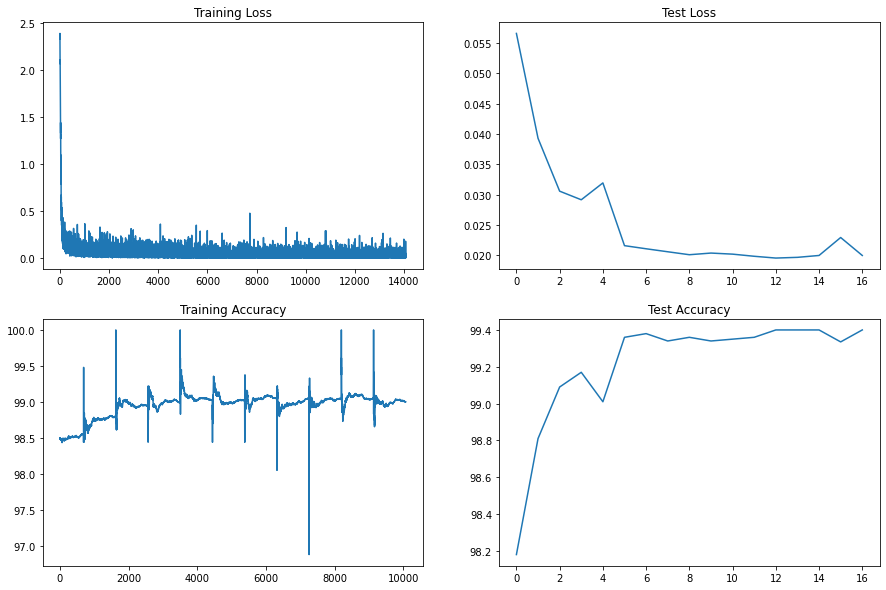

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")